# Clone

In [24]:
!git clone https://github.com/TencentARC/GFPGAN.git
%cd GFPGAN

!pip uninstall -y jax jaxlib tensorflow tensorboard

!pip install numpy==1.23.5
!pip install torch torchvision
!pip install basicsr>=1.4.2 facexlib>=0.3.0 gfpgan>=1.3.8 realesrgan>=0.3.0
!pip install opencv-python scipy tqdm lmdb pyyaml yapf

Cloning into 'GFPGAN'...
remote: Enumerating objects: 527, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 527 (delta 170), reused 154 (delta 154), pack-reused 315 (from 2)
Receiving objects: 100% (527/527), 5.38 MiB | 34.84 MiB/s, done.
Resolving deltas: 100% (281/281), done.
/kaggle/working/GFPGAN/GFPGAN
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, which is not installed.
dopamine-

In [25]:
import os
import shutil
import random
from tqdm import tqdm
import io
import cv2
import numpy as np
from PIL import Image

import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt

In [3]:
# SỬA TRONG LIB
file_path = "/usr/local/lib/python3.11/dist-packages/basicsr/data/degradations.py"

# Đọc nội dung
with open(file_path, "r") as f:
    content = f.read()

# Thay đổi dòng import lỗi
content = content.replace(
    "from torchvision.transforms.functional_tensor import rgb_to_grayscale",
    "from torchvision.transforms.functional import rgb_to_grayscale"
)

# Ghi lại nội dung đã sửa
with open(file_path, "w") as f:
    f.write(content)

print("Đã sửa lỗi import trong degradations.py")

Đã sửa lỗi import trong degradations.py


In [4]:
from gfpgan.archs.gfpganv1_clean_arch import GFPGANv1Clean
from torch.amp import autocast, GradScaler
from torchvision import models

# Degrade Image

In [5]:
src_dir = "/kaggle/input/flickrfaceshq-dataset-ffhq"
gt_dir  = "/kaggle/working/datasets/gt"
num_images = 30000  # tổng ảnh GT
os.makedirs(gt_dir, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ========== 1. Copy 30k ảnh FFHQ ==========
all_images = sorted([f for f in os.listdir(src_dir)
                     if f.lower().endswith(('.png','.jpg','.jpeg','.bmp'))])
selected = all_images[:num_images]
print(f"Copying up to {len(selected)} images to GT...")
for img_name in tqdm(selected, desc="Linking GT images"):
    src = os.path.join(src_dir, img_name)
    dst = os.path.join(gt_dir, img_name)
    try:
        os.link(src, dst)
    except OSError:
        try:
            import shutil; shutil.copy(src, dst)
        except Exception:
            continue

# ========== 2. Degrade functions ==========
def random_blur(img):
    k = random.choice([3,5,7]); 
    return cv2.GaussianBlur(img,(k,k),0)

def random_resize(img, scale_range=(0.5,2)):
    h,w = img.shape[:2]; s = random.uniform(*scale_range)
    return cv2.resize(img,(int(w*s),int(h*s)),
                      interpolation=random.choice([cv2.INTER_LINEAR,cv2.INTER_AREA,cv2.INTER_CUBIC]))

def add_gaussian_noise(img, sigma_range=(5,15)):
    sigma = random.uniform(*sigma_range)
    noise = np.random.normal(0,sigma,img.shape).astype(np.float32)
    return np.clip(img.astype(np.float32)+noise,0,255).astype(np.uint8)

def jpeg_compress(img, quality_range=(30,60)):
    q = random.randint(*quality_range)
    _,enc = cv2.imencode('.jpg',img,[int(cv2.IMWRITE_JPEG_QUALITY),q])
    return cv2.imdecode(enc,1)

def full_degradation_pipeline(pil_img):
    img = np.array(pil_img)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    img = random_blur(img)
    img = random_resize(img)
    img = add_gaussian_noise(img)
    img = jpeg_compress(img)
    return img  # BGR uint8

Copying up to 1000 images to GT...


Linking GT images: 100%|██████████| 1000/1000 [00:14<00:00, 67.08it/s]


Copying up to 30000 images to GT...


Linking GT images: 100%|██████████| 30000/30000 [07:04<00:00, 70.66it/s]


# Dataloader

In [6]:
# ========== 3. Dataset on-the-fly ==========
class OnTheFlyDataset(Dataset):
    def __init__(self, gt_root, files, transform=None):
        self.gt_root  = gt_root
        self.files    = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        # Load GT
        gt = Image.open(os.path.join(self.gt_root, fname)).convert('RGB')
        # Degrade
        lq_bgr = full_degradation_pipeline(gt)
        lq = Image.fromarray(cv2.cvtColor(lq_bgr, cv2.COLOR_BGR2RGB))
        # Transform to tensor
        if self.transform:
            gt = self.transform(gt)
            lq = self.transform(lq)
        return lq, gt

transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
])

dataset     = OnTheFlyDataset(gt_dir, selected, transform)
train_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ========== 5. Initialize GFPGAN and freeze/unfreeze ==========
model = GFPGANv1Clean(
    out_size=512,
    num_style_feat=512,
    channel_multiplier=2,
    narrow=1,
    sft_half=True
).to(device)

ckpt = torch.load(
    "/kaggle/input/models-for-finetune/pretrained_models/GFPGANv1.4.pth",
    map_location=device,
    weights_only=True
)
model.load_state_dict(ckpt, strict=False)

_IncompatibleKeys(missing_keys=['conv_body_first.weight', 'conv_body_first.bias', 'conv_body_down.0.conv1.weight', 'conv_body_down.0.conv1.bias', 'conv_body_down.0.conv2.weight', 'conv_body_down.0.conv2.bias', 'conv_body_down.0.skip.weight', 'conv_body_down.1.conv1.weight', 'conv_body_down.1.conv1.bias', 'conv_body_down.1.conv2.weight', 'conv_body_down.1.conv2.bias', 'conv_body_down.1.skip.weight', 'conv_body_down.2.conv1.weight', 'conv_body_down.2.conv1.bias', 'conv_body_down.2.conv2.weight', 'conv_body_down.2.conv2.bias', 'conv_body_down.2.skip.weight', 'conv_body_down.3.conv1.weight', 'conv_body_down.3.conv1.bias', 'conv_body_down.3.conv2.weight', 'conv_body_down.3.conv2.bias', 'conv_body_down.3.skip.weight', 'conv_body_down.4.conv1.weight', 'conv_body_down.4.conv1.bias', 'conv_body_down.4.conv2.weight', 'conv_body_down.4.conv2.bias', 'conv_body_down.4.skip.weight', 'conv_body_down.5.conv1.weight', 'conv_body_down.5.conv1.bias', 'conv_body_down.5.conv2.weight', 'conv_body_down.5.con

# Finetune

In [8]:
# Freeze all parameters
for p in model.parameters():
    p.requires_grad = False
    
# Freeze encoder hoàn toàn
for name, module in model.named_modules():
    if 'encoder' in name:
        module.eval()
        for p in module.parameters():
            p.requires_grad = False

for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

# Chỉ unfreeze final_conv của decoder
for name, param in model.named_parameters():
    if name.startswith("stylegan_decoder.style_mlp") \
       or name.startswith("final_conv") \
       or name.startswith("conv_body_up"):
        param.requires_grad = True
    else:
        param.requires_grad = False

# ========== 6. Optimizer, Loss, AMP ==========
# Tạo optimizer chỉ cho các param requires_grad=True
style_params = [p for n,p in model.named_parameters() if 'style_mlp' in n]
up_params    = [p for n,p in model.named_parameters() if ('conv_body_up' in n or 'final_conv' in n)]
optimizer = torch.optim.Adam([
    {'params': style_params, 'lr': 1e-4},
    {'params': up_params,    'lr': 1e-4},
], betas=(0.95,0.999))

# Kiểm tra số lượng tham số được fine-tune
total = sum(p.numel() for p in model.parameters())
trainable = [p for p in model.parameters() if p.requires_grad]
tunned = sum(p.numel() for p in trainable)
print(f"Total params: {total:,}, tuning params: {tunned:,}")

def denormalize(tensor):
    img = tensor * 0.5 + 0.5
    return img.clamp(0,1).permute(1,2,0).cpu().numpy()

Total params: 54,979,292, tuning params: 8,879,008


In [9]:
epochs = 5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

criterion = torch.nn.L1Loss()
scaler    = GradScaler(device)

# Perceptual loss (VGG-based)
from torchvision.models import vgg19
vgg = vgg19(pretrained=True).features[:16].to(device).eval()
def perc_loss(x, y):
    return torch.nn.functional.l1_loss(
        vgg((x + 1) / 2),
        vgg((y + 1) / 2)
    )

# ——————————————————————————————————————————————
# 3) Train loop
# ——————————————————————————————————————————————
def train_one_epoch():
    model.train()
    total_loss = 0.0
    for lq, gt in tqdm(train_loader, desc="Training Epoch"):
        lq, gt = lq.to(device), gt.to(device)
        optimizer.zero_grad()

        with autocast(device_type="cuda"):
            out = model(lq)[0]                # unpack output
            l1 = criterion(out, gt)           # reconstruction loss
            p  = perc_loss(out, gt)           # perceptual loss
            loss = l1 + 0.01 * p              # tổng loss

        scaler.scale(loss).backward()
        # Gradient clipping để ổn định
        torch.nn.utils.clip_grad_norm_(trainable, max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * lq.size(0)

    return total_loss / len(train_loader.dataset)

if __name__ == "__main__":
    for ep in range(1, epochs+1):
        loss = train_one_epoch()
        print(f"Epoch {ep}/{epochs} — Loss: {loss:.4f}")

        # Save checkpoint weights
        torch.save({'params': model.state_dict()}, f"finetuned_ckpt_ep{ep}.pth")

        # Scheduler step
        scheduler.step()

        # Sample và lưu kết quả để kiểm tra
        model.eval()
        with torch.no_grad():
            lq_s, gt_s = next(iter(train_loader))
            lq_s, gt_s = lq_s.to(device), gt_s.to(device)
            out_s = model(lq_s)[0]

        fig, axes = plt.subplots(3, 1, figsize=(4, 12))
        axes[0].imshow(denormalize(lq_s[0])); axes[0].set_title("LQ");   axes[0].axis("off")
        axes[1].imshow(denormalize(out_s[0])); axes[1].set_title("Output"); axes[1].axis("off")
        axes[2].imshow(denormalize(gt_s[0])); axes[2].set_title("GT");   axes[2].axis("off")
        plt.tight_layout()
        plt.savefig(f"sample_ep{ep}.png")
        plt.close(fig)

        torch.cuda.empty_cache()

In [10]:
torch.save({'params': model.state_dict()}, 'finetuned_weights_final.pth')

In [11]:
torch.save(model, "finetuned_full.pth")

In [26]:
from gfpgan import GFPGANer
import torch, cv2, os

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- 1) Load your fine-tuned model instance ---
from gfpgan import models as gfpgan_models
model = GFPGANv1Clean(
    out_size=512,
    num_style_feat=512,
    channel_multiplier=2,
    narrow=1,
    sft_half=True
).to(device)
ckpt = torch.load("/kaggle/input/cv-cuoiky-finetuned/finetuned_ckpt_ep3.pth", map_location=device, weights_only=True)
# if you saved state_dict under 'params':
model.load_state_dict(ckpt["params"], strict=True)
model.eval()

# --- 2) Init GFPGANer with any compatible checkpoint (we won't use its weights) ---
#    We just want its .enhance() logic.
dummy_ckpt = "/kaggle/input/models-for-finetune/pretrained_models/GFPGANv1.4.pth"
restorer = GFPGANer(
    model_path=dummy_ckpt,
    upscale=1,
    arch="clean",
    channel_multiplier=2,
    bg_upsampler=None,
    device=device
)

restorer.gfpgan = model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth" to /kaggle/working/GFPGAN/GFPGAN/gfpgan/weights/detection_Resnet50_Final.pth



100%|██████████| 104M/104M [00:00<00:00, 335MB/s] 
/usr/local/lib/python3.11/dist-packages/facexlib/detection/__init__.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  l

Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.2.2/parsing_parsenet.pth" to /kaggle/working/GFPGAN/GFPGAN/gfpgan/weights/parsing_parsenet.pth



100%|██████████| 81.4M/81.4M [00:00<00:00, 338MB/s]
/usr/local/lib/python3.11/dist-packages/facexlib/parsing/__init__.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lo

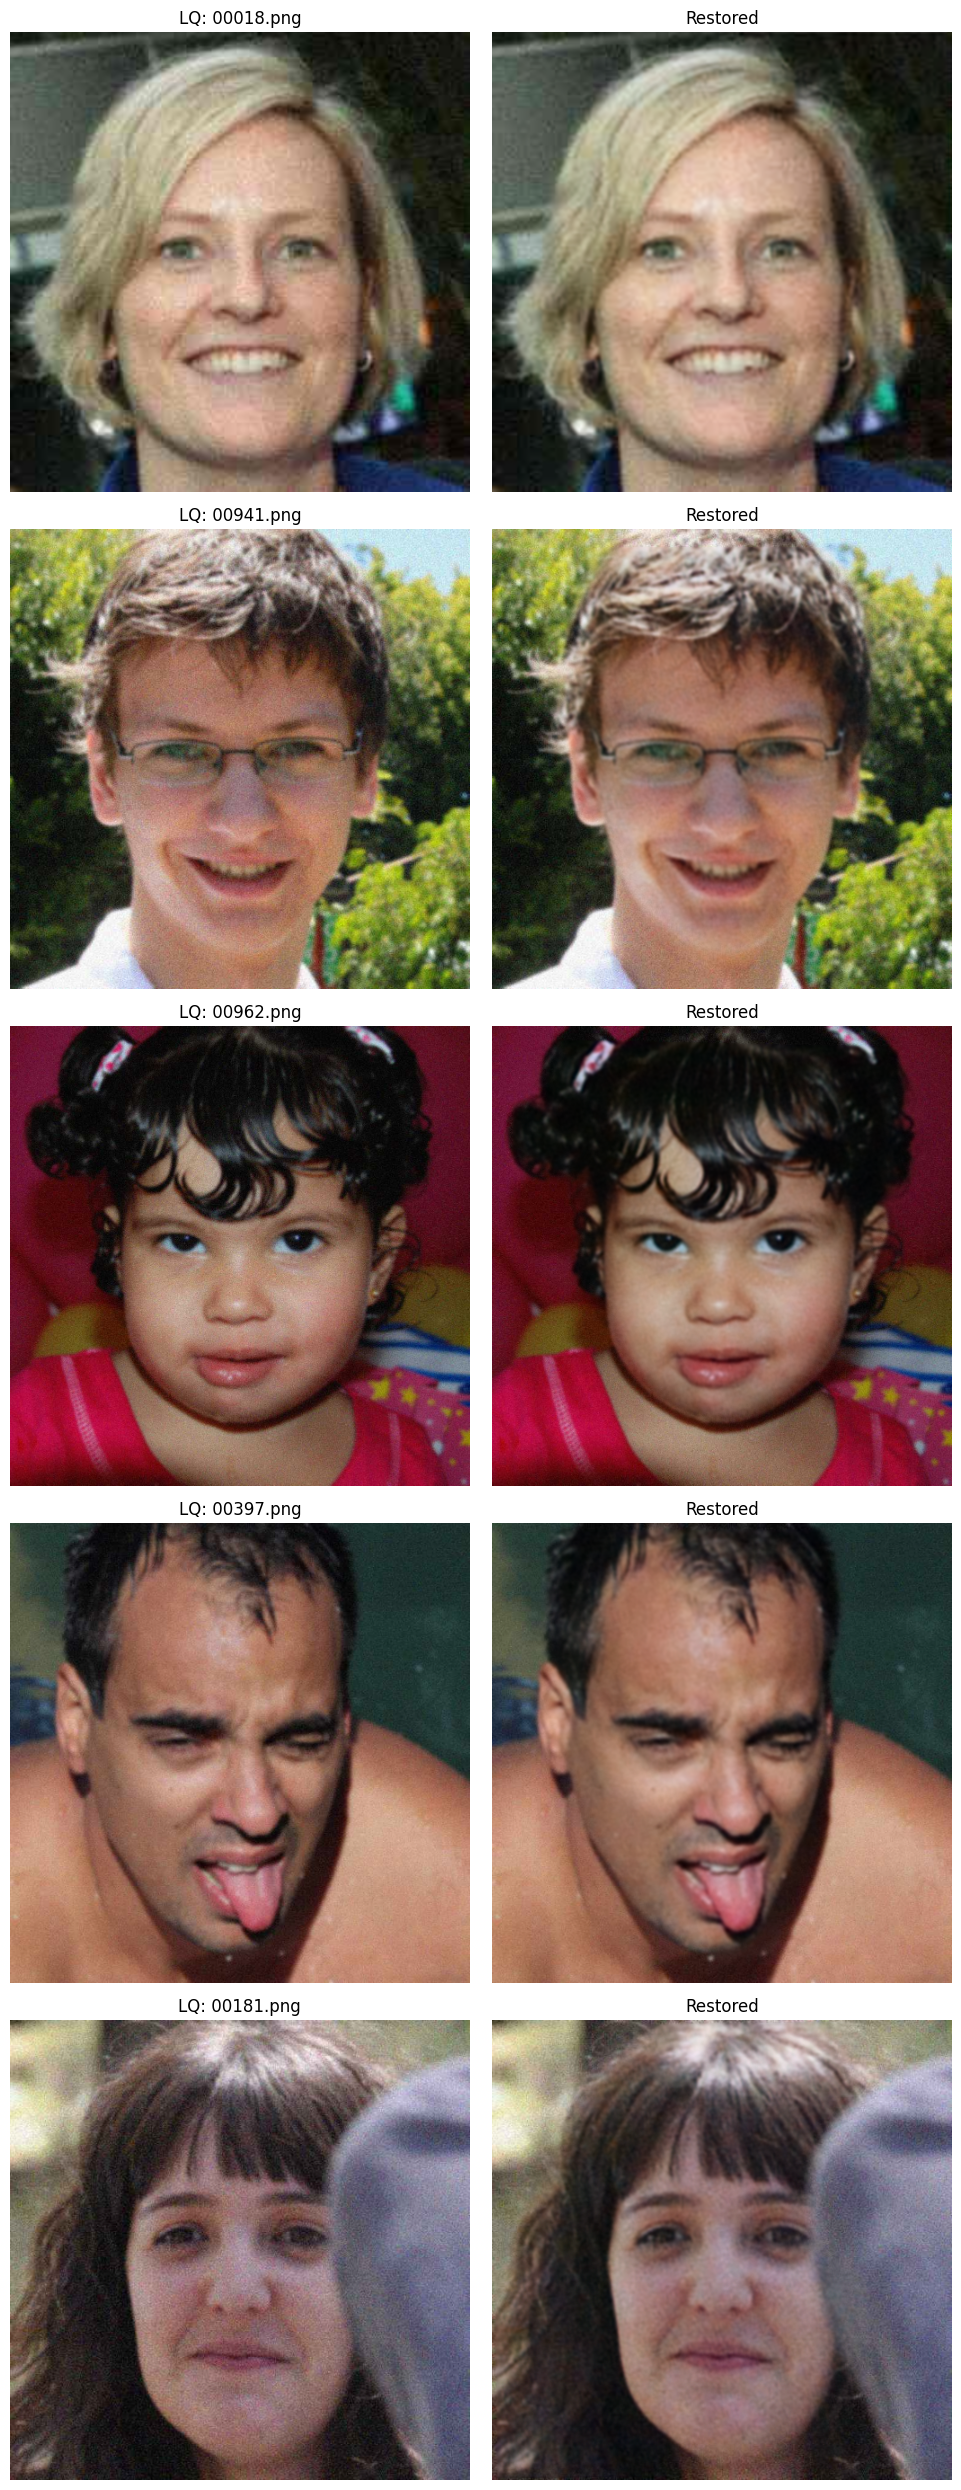

In [51]:
# 3) Select 5 images and plot comparison

def full_degradation_pipeline(pil_img):
    img = np.array(pil_img)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    img = random_blur(img)
    img = random_blur(img)
    img = random_resize(img)
    img = add_gaussian_noise(img)
    img = add_gaussian_noise(img)
    img = jpeg_compress(img)
    return img  # BGR uint8
    
input_dir = "/kaggle/working/datasets/gt"
files = [f for f in os.listdir(input_dir)
         if f.lower().endswith((".png",".jpg",".jpeg"))][:5]

fig, axes = plt.subplots(5, 2, figsize=(10, 25))
for i, fname in enumerate(files):
    img_path = os.path.join(input_dir, fname)
    img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_bgr = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    # Tạo LQ trước khi restore
    img_degraded = full_degradation_pipeline(img_bgr.copy())
    img_degraded = cv2.resize(img_degraded, (512, 512), interpolation=cv2.INTER_LINEAR)

    # Restore
    _,_,output = restorer.enhance(
        img_degraded,
        has_aligned=False,
        only_center_face=True,
        paste_back=True
    )
    
    # outs[0] is restored image, unwrap list if needed
    restored = output
    if isinstance(output, list):
        restored = output[0]

    # Chuyển về BGR numpy
    if isinstance(restored, Image.Image):
        restored_bgr = cv2.cvtColor(np.array(restored), cv2.COLOR_RGB2BGR)
    else:
        restored_bgr = restored
    
    # Vẽ so sánh 2 ảnh và highlight phần khác biệt    
    # tính độ khác biệt
    # diff = np.abs(restored_bgr.astype(int) - cv2.cvtColor(img_degraded, cv2.COLOR_BGR2RGB).astype(int))
    # mask = (diff.sum(axis=2) != 0)

    # Plot
    lq_rgb     = cv2.cvtColor(img_degraded, cv2.COLOR_BGR2RGB)
    restored_rgb = cv2.cvtColor(restored_bgr, cv2.COLOR_BGR2RGB)

    axes[i,0].imshow(lq_rgb)
    axes[i,0].set_title(f"LQ: {fname}")
    axes[i,0].axis("off")
    
    axes[i,1].imshow(restored_rgb)
    axes[i,1].set_title("Restored")
    axes[i,1].axis("off")

plt.tight_layout()
plt.show()

# Thử thêm A loss